In [1]:
import torch
import numpy as np

print(f'Cuda available: {torch.cuda.is_available()}')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on: {device}, Device count: {torch.cuda.device_count()}')

Cuda available: True
Running on: cuda:0, Device count: 2


#### Init dataset

In [2]:
from nuscenes import NuScenes
from custom_prediction.helper import PredictHelper

In [3]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = 'D:/ThesisProjects/nuScenes_dataset/'

nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)

In [4]:
helper = PredictHelper(nusc)

In [5]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

train = get_prediction_challenge_split("train", dataroot=DATAROOT)
validation = get_prediction_challenge_split("train_val", dataroot=DATAROOT)
test = get_prediction_challenge_split("val", dataroot=DATAROOT)

print(f'train/val/test: {len(train), len(validation), len(test)}')
train[:5]

train/val/test: (32186, 8560, 9041)


['4d87aaf2d82549969f1550607ef46a63_faf2ea71b30941329a3c3f3866cec714',
 '4d87aaf2d82549969f1550607ef46a63_fa3f3d82b2b94da39f67bffc4e16d5db',
 '4d87aaf2d82549969f1550607ef46a63_903f32e4fd8247de8f20aa989e157b2a',
 '4d87aaf2d82549969f1550607ef46a63_ab44d8e463d54d0ebb18eb66bbc1e5eb',
 '4d87aaf2d82549969f1550607ef46a63_cc5951ca9cb240d5a7a0738fdec37634']

In [6]:
# instance_token, sample_token = train[480].split("_")
instance_token, sample_token = train[0].split("_")

In [7]:
history_length = 2
prediction_length = 6

#### Image saver

In [8]:
from custom_prediction.custom_input_representation.static_layers import StaticLayerRasterizer
from custom_prediction.custom_input_representation.agents import AgentBoxesWithFadedHistory, AgentBoxesWithFutureTrajectory
from custom_prediction.custom_input_representation.interface import InputRepresentation
from custom_prediction.custom_input_representation.combinators import Rasterizer

from typing import Dict

def generate_input_representation(instance_token, sample_token):
    #TODO: Move class initialization away from method
    static_layer_rasterizer = StaticLayerRasterizer(helper)
    agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)

    mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

    img = mtp_input_representation.make_input_representation(instance_token, sample_token)

    return img

In [9]:
import matplotlib.pyplot as plt

def show_img(img, size=4):
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

Gen time: 1.008 sec; shape: (500, 500, 3)


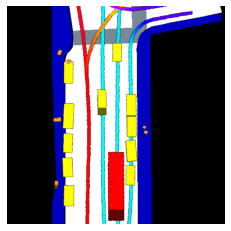

In [10]:
import time

start_time = time.time()

img = generate_input_representation(instance_token, sample_token)
print(f'Gen time: {round(time.time() - start_time, 3)} sec; shape: {img.shape}')

show_img(img)

#### State saver

In [14]:
import numpy as np

max_velocity = 26.0
min_accel = -26.0
max_accel = 26.0
min_heading_cr = -1.5
max_heading_cr = 1.5

def value_normalization(value, min_border, max_border):
    if np.isnan(value):
        return -1
    return (value - min_border) / (max_border - min_border)

def get_agent_state(instance_token, sample_token):
    
    # Meters / second.
    vel = helper.get_velocity_for_agent(instance_token, sample_token)

    # Meters / second^2.
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)

    # Radians / second.
    heading_cr = helper.get_heading_change_rate_for_agent(instance_token, sample_token)
    
    #print(f'before: {vel} {accel} {heading_cr}')
    
    vel = value_normalization(vel, 0, max_velocity)
    accel = value_normalization(accel, min_accel, max_accel)
    heading_cr = value_normalization(heading_cr, min_heading_cr, max_heading_cr)
                
    state = np.array([vel, accel, heading_cr])
    
    return state

In [15]:
get_agent_state(instance_token, sample_token)

array([ 0.187407  , -1.        ,  0.49709033])

#### Future trajectory saver

In [13]:
def PlotPathWithPrediction(future, predict=[]):
    plt.figure(figsize=(6, 6))

    plt.scatter(future[:, 1], -future[:, 0], c='g', s=10)
    
    if len(predict) > 0:
        plt.scatter(predict[:, 1], -predict[:, 0], c='yellow', s=10)

    # Keep aspect ratio of axis
    plt.axis('equal')
    plt.show()

In [14]:
def get_future_trajectory(instance_token, sample_token):
    gt = helper.get_future_for_agent(instance_token, sample_token, prediction_length, in_agent_frame=True)
    return gt.flatten()

In [15]:
gt = get_future_trajectory(instance_token, sample_token)

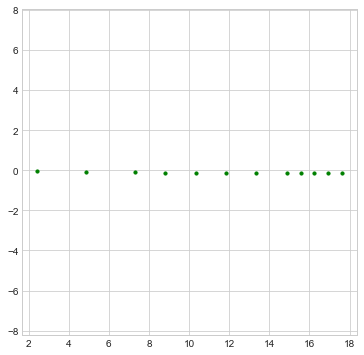

In [16]:
PlotPathWithPrediction(np.reshape(gt, (-1, 2)))

### TODO: Dataset creation

In [9]:
from enum import Enum

class DatasetColumns(Enum):
    FEATURES = 1
    STATES = 2
    LABELS = 3

In [10]:
from tqdm import tqdm

NPY_DATAROOT = './npy_dataset/'

def get_empty_column_batch(samples, column_id):
    if column_id == DatasetColumns.FEATURES:
        return np.empty([len(samples), 500*500*3], dtype=np.uint8)
    
    if column_id == DatasetColumns.STATES:
        return np.empty([len(samples), 3])

    if column_id == DatasetColumns.LABELS:
        return np.empty([len(samples), 2*2*prediction_length])


def generate_column_batch(samples, column_id, file_name):
    
    column_batch = get_empty_column_batch(samples, column_id)
    
    for i, x in enumerate(tqdm(column_batch)):
        instance_token, sample_token = samples[i].split("_")
        
        if column_id == DatasetColumns.FEATURES:
            img = generate_input_representation(instance_token, sample_token)
            row = img.flatten()
            
        if column_id == DatasetColumns.STATES:                
            row = get_agent_state(instance_token, sample_token)
        
        if column_id == DatasetColumns.LABELS:
            row = helper.get_future_for_agent(instance_token, sample_token, prediction_length, in_agent_frame=True)
            row = row.flatten()
            
        column_batch[i] = row
        
    np.save(f"{NPY_DATAROOT}{file_name}.npy", column_batch)

In [11]:
# Сохраняет по батчам
batch_size = 50000

def generate_column(samples, column_id, file_name):
    
    for i in range(int(len(samples) / batch_size) + 1):
        
        from_sample = i * batch_size
        to_sample = min((i + 1) * batch_size, len(samples))
        
        print(f"[{i}]{from_sample}:{to_sample}")
        
        batch = samples[from_sample : to_sample]
        generate_column_batch(batch, column_id, file_name + f'_p{i}')

In [44]:
### Test range
before = []
after = []

for sample in validation:
    instance_token, sample_token = sample.split("_")
    
    # Meters / second.
    vel = helper.get_velocity_for_agent(instance_token, sample_token)

    # Meters / second^2.
    accel = helper.get_acceleration_for_agent(instance_token, sample_token)

    # Radians / second.
    heading_cr = helper.get_heading_change_rate_for_agent(instance_token, sample_token)
    
    before.append(accel)
        
    vel = value_normalization(vel, 0, max_velocity)
    accel = value_normalization(accel, min_accel, max_accel)
    heading_cr = value_normalization(heading_cr, min_heading_cr, max_heading_cr)
    
    after.append(accel)
    

In [43]:
before = [x for x in before if abs(x) > 8]

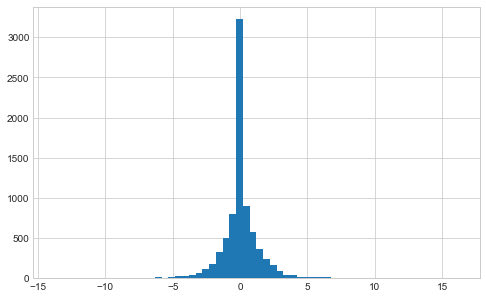

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(before, 60, align='mid')
plt.show()

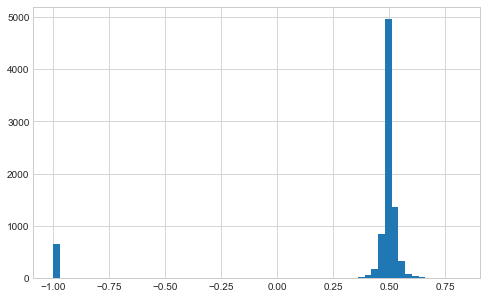

In [46]:
plt.figure(figsize=(8,5))
plt.hist(after, 60, align='mid')
plt.show()

In [22]:
generate_column(train, DatasetColumns.STATES, 'norm_train_states')

[0]0:32186


100%|██████████████████████████████████████████████████████████████████████████| 32186/32186 [00:04<00:00, 7300.98it/s]


In [23]:
generate_column(validation, DatasetColumns.STATES, 'norm_validation_states')

[0]0:8560


100%|████████████████████████████████████████████████████████████████████████████| 8560/8560 [00:01<00:00, 7781.57it/s]


### Try to read data and check

In [52]:
import numpy as np

loaded_img = np.load(f'{NPY_DATAROOT}test.npy')
# loaded_states = np.load(f'{NPY_DATAROOT}multiagent_test_states_2k.npy')
# loaded_labels = np.load(f'{NPY_DATAROOT}multiagent_test_labels_2k.npy')

In [53]:
len(loaded_img) #, len(loaded_states), len(loaded_labels)

9041

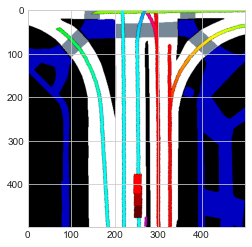

In [58]:
index_to_check = 150

img = loaded_img[index_to_check]
img = img.reshape((500, 500, 3))

plt.imshow(img)
plt.show()